In [1]:
import sys
sys.path.append('..')
from pathlib import Path
import cv2
from utils import *
import train_config as config
from segment_vision_log import setup_model
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 3

In [2]:
try:
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.family"] = "Times New Roman"
except:
    pass

In [3]:
best_run_path = "../rci_results/RCI_256_Small_NoDecay_IntenseAffineTransforms_20-12-2023_11-08-09"
seg = setup_model(best_run_path).to(config.config['device'])

In [27]:
# YOLO
from ultralytics import YOLO
yolo_weights = "/Users/davidkorcak/Documents/eForce/fsoco_yolo/runs/detect/train_v8small_new_dataset_1280_mosaic/weights/best.pt"

yolo = YOLO(yolo_weights)

yolo_opts = {
    "conf": 0.4,
    "iou": 0.5,
    "imgsz": 1280,
    "device": "mps",
}

class_color_map = {
    1: (255, 0, 0),  # blue
    0: (0, 255, 255),  # yellow
    2: (0, 191, 255),  # orange
    3: (0, 0, 255),  # red
}


def yolo_pred_to_bgr_img(img, pred):
    for result in pred:
        for bbox in result.boxes.data.cpu().detach().numpy():
            x1, y1, x2, y2, conf, cls = bbox
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cls = int(cls)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), class_color_map[cls], 2)
            img = cv2.putText(img, f"{conf:.1f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, class_color_map[cls], 2, cv2.LINE_AA)
    return img

In [10]:
img_path = "/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/vision_for_testing/cone_people.jpeg"
img_array = cv2.imread(img_path)
rgb_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
print("Image size:", rgb_img.shape)
if rgb_img.shape[0] > 1280 and rgb_img.shape[0] > rgb_img.shape[1]:
    rgb_img = cv2.resize(rgb_img, (int(1280 * rgb_img.shape[1] / rgb_img.shape[0]), 1280))
    print("New image size:", rgb_img.shape)
    plt.imshow(rgb_img)

Image size: (700, 700, 3)


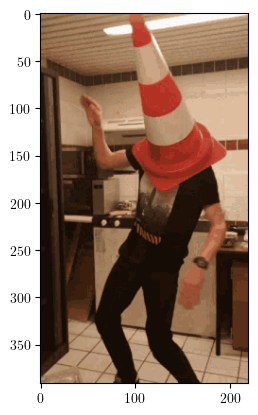

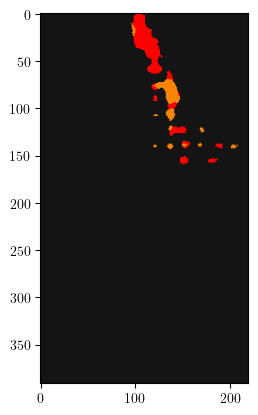

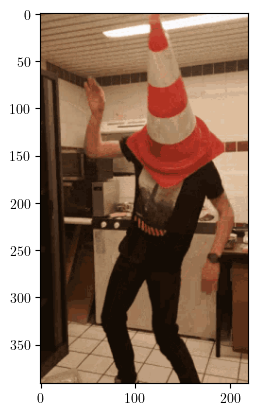

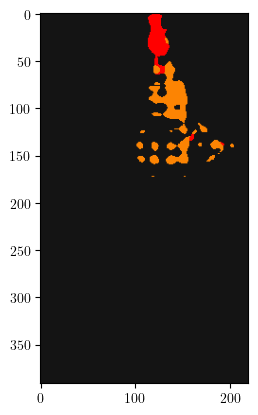

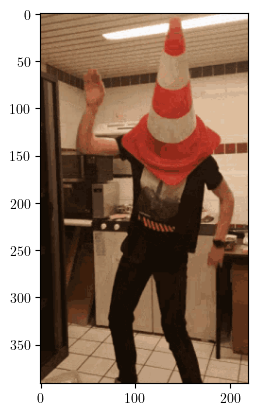

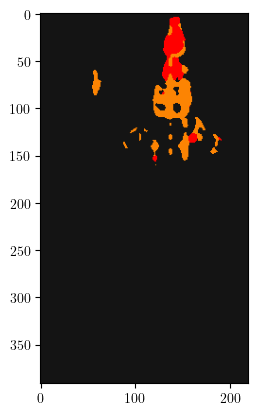

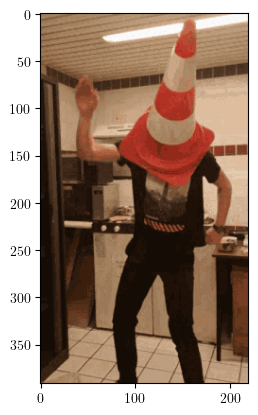

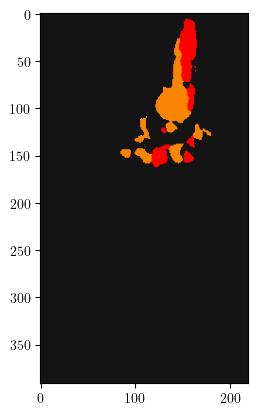

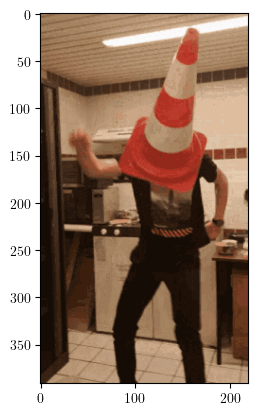

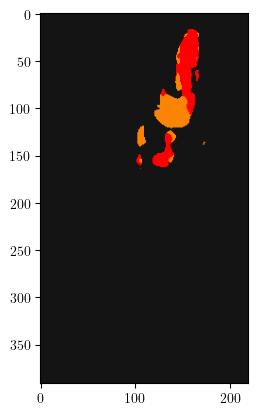

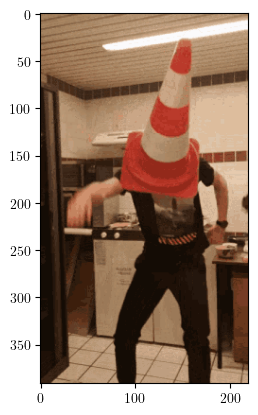

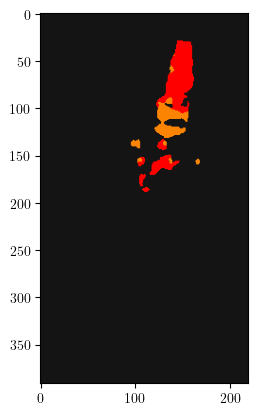

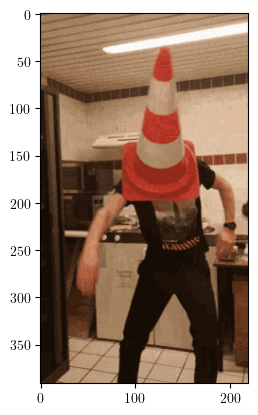

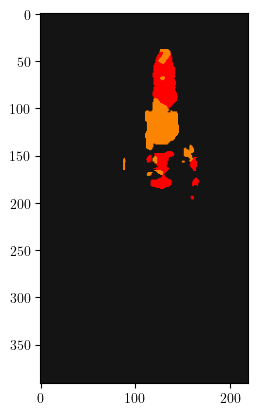

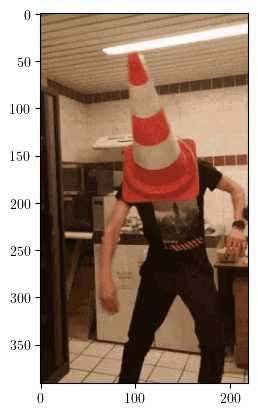

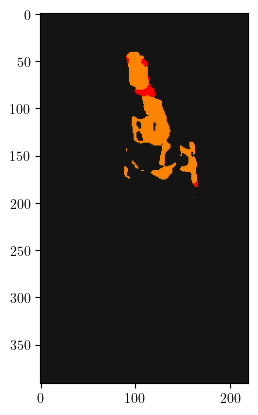

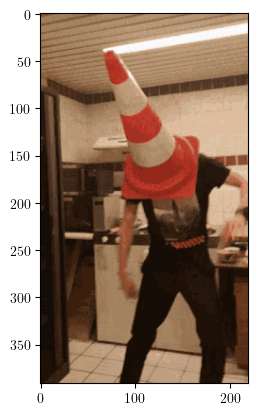

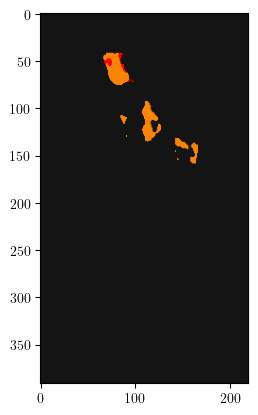

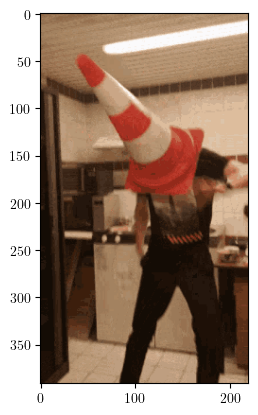

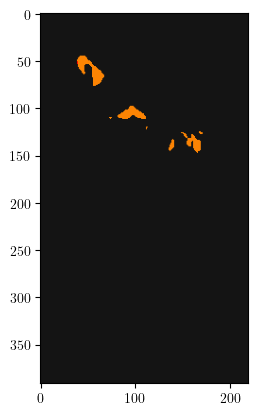

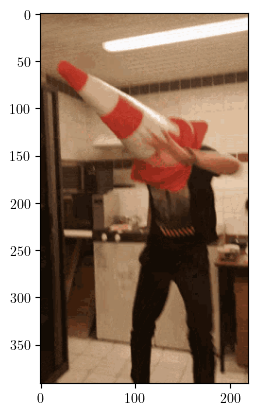

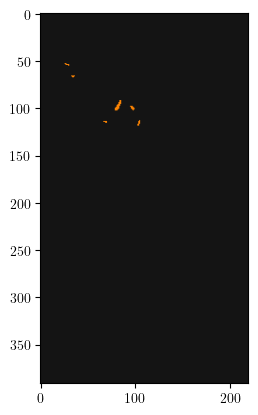

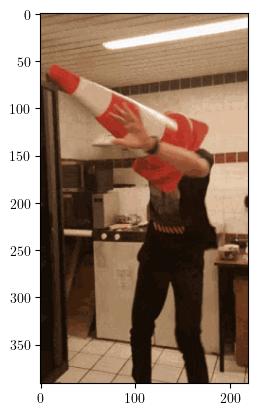

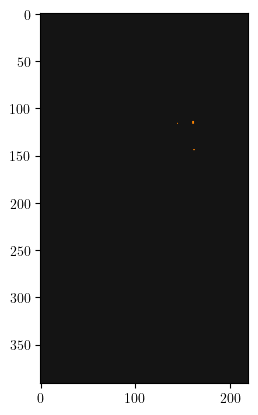

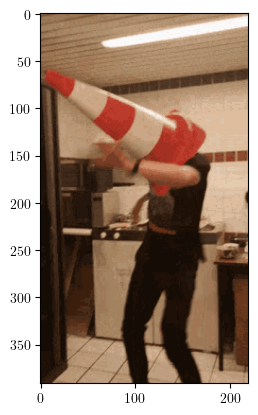

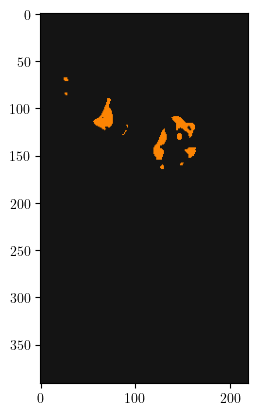

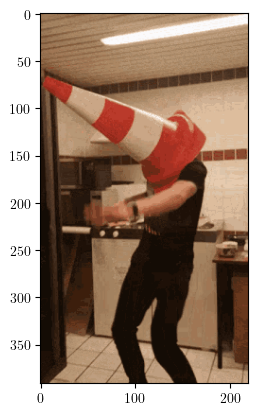

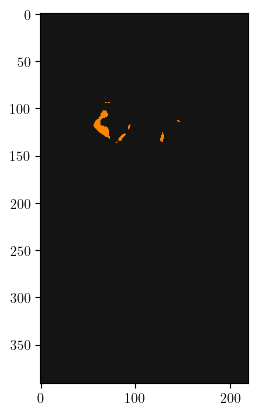

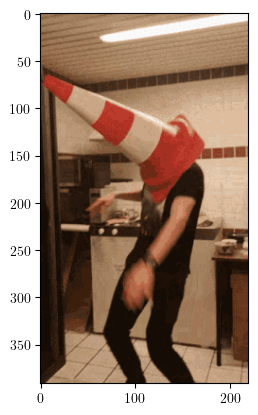

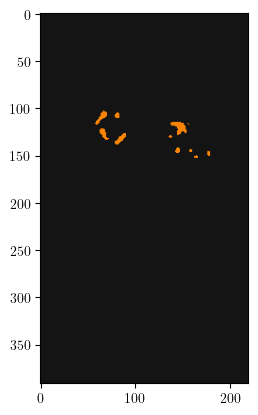

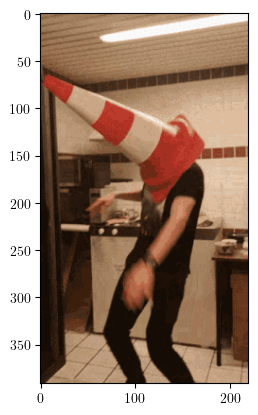

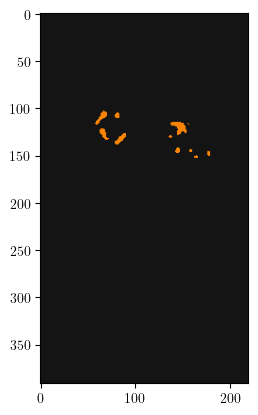

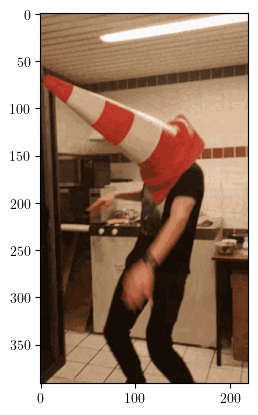

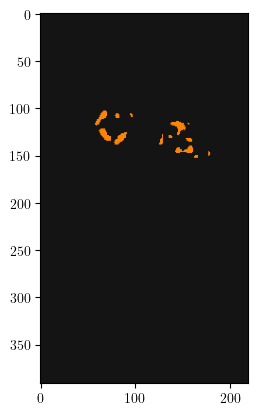

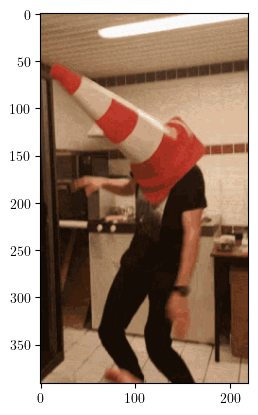

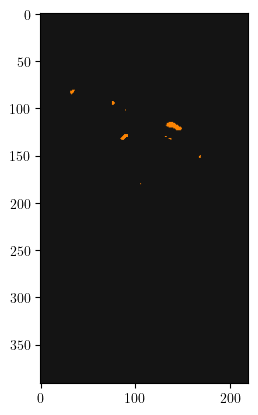

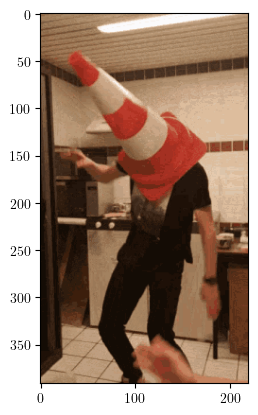

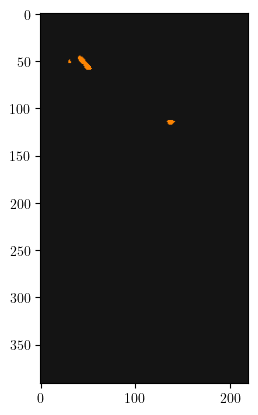

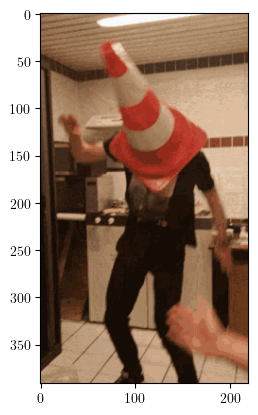

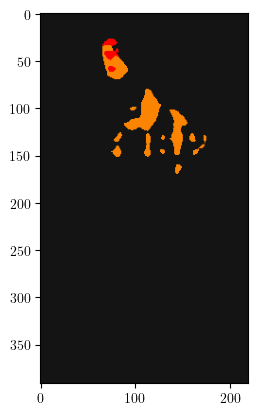

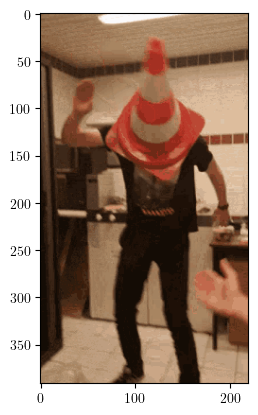

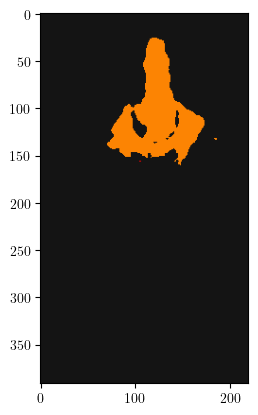

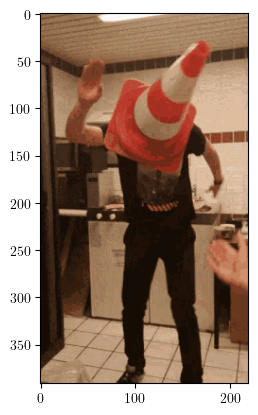

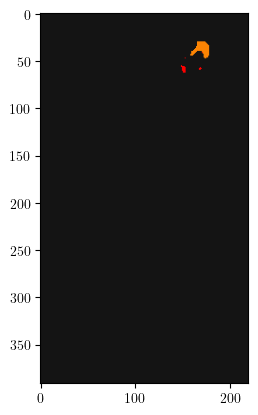

In [16]:
# Cone dance gif 
cap = cv2.VideoCapture("/Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/vision_for_testing/conedance.gif")
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.show()
    img_tensor = rgb_image_to_tensor(frame, transform=Normalize()).to(config.config['device'])
    seg_pred = seg(img_tensor).squeeze().cpu().detach()
    mask_img = mask_tensor_to_rgb(seg_pred)
    plt.imshow(mask_img)
    plt.show()
cap.release()

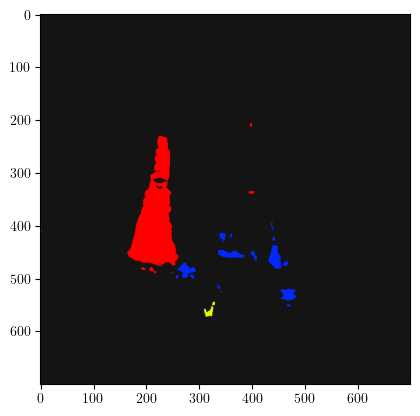

In [11]:
#  Segmentation
img_tensor = rgb_image_to_tensor(rgb_img, transform=Normalize())
seg_pred = seg(img_tensor.to(config.config["device"])).squeeze().cpu().detach()
mask_img = mask_tensor_to_rgb(seg_pred)
plt.imshow(mask_img)

In [37]:
# Object detection
yolo_pred = yolo(img_path, **yolo_opts)
annotated_img = yolo_pred_to_bgr_img(img_array.copy(), yolo_pred)
annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)


image 1/1 /Users/davidkorcak/Documents/ctu/ctu_sem3/urob/hws/urob_cone_seg/vision_for_testing/cone_image.jpg: 736x1280 6 yellow_cones, 2 blue_cones, 2 large_orange_cones, 854.2ms
Speed: 127.9ms preprocess, 854.2ms inference, 26.7ms postprocess per image at shape (1, 3, 736, 1280)


In [47]:
mask_with_bboxes = cv2.addWeighted(mask_img, 0.8, annotated_img, 0.6, 0)

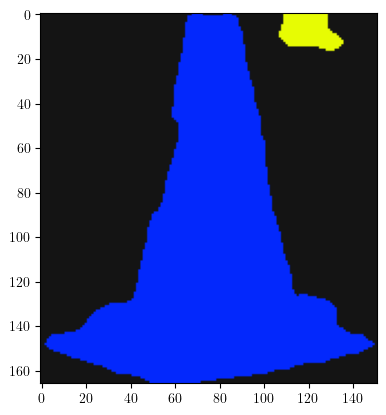

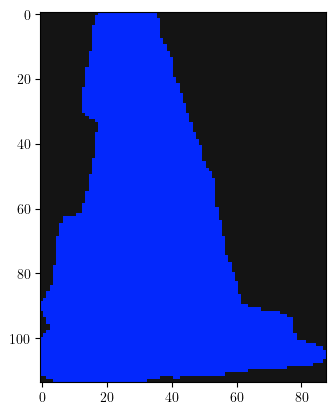

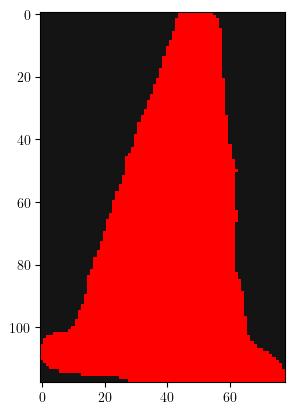

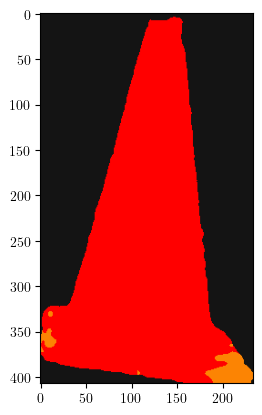

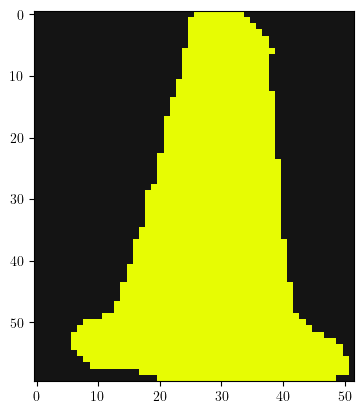

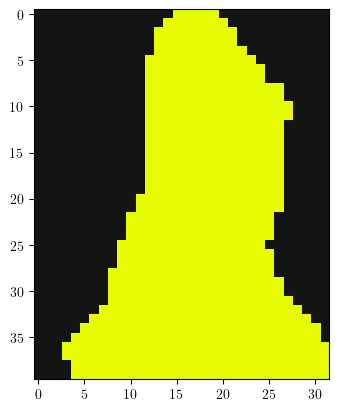

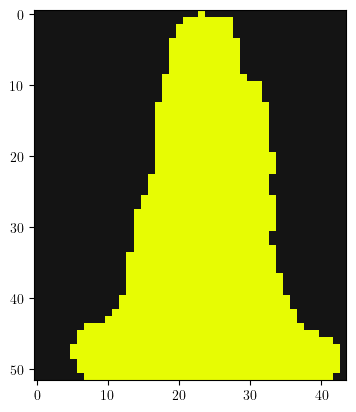

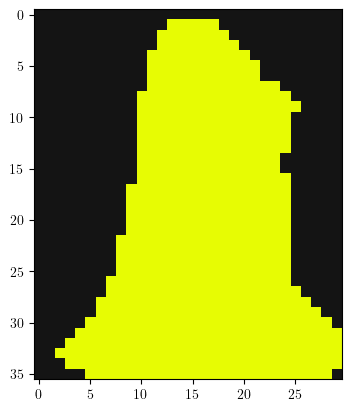

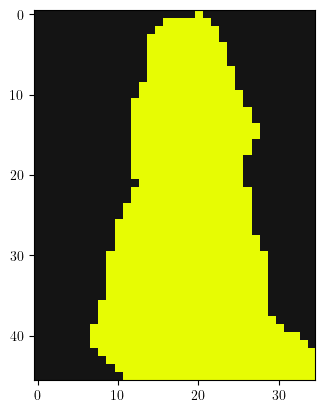

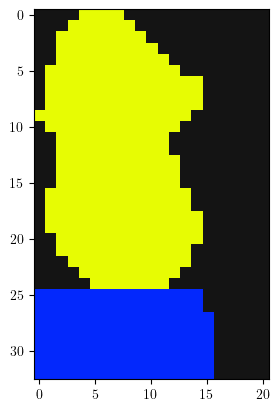

In [49]:
# For each of the yolo predictions, crop the mask
for result in yolo_pred:
    for bbox in result.boxes.data.cpu().detach().numpy():
        x1, y1, x2, y2, conf, cls = bbox
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cls = int(cls)
        mask_crop = mask_img[y1:y2, x1:x2]
        plt.imshow(mask_crop)
        plt.show()

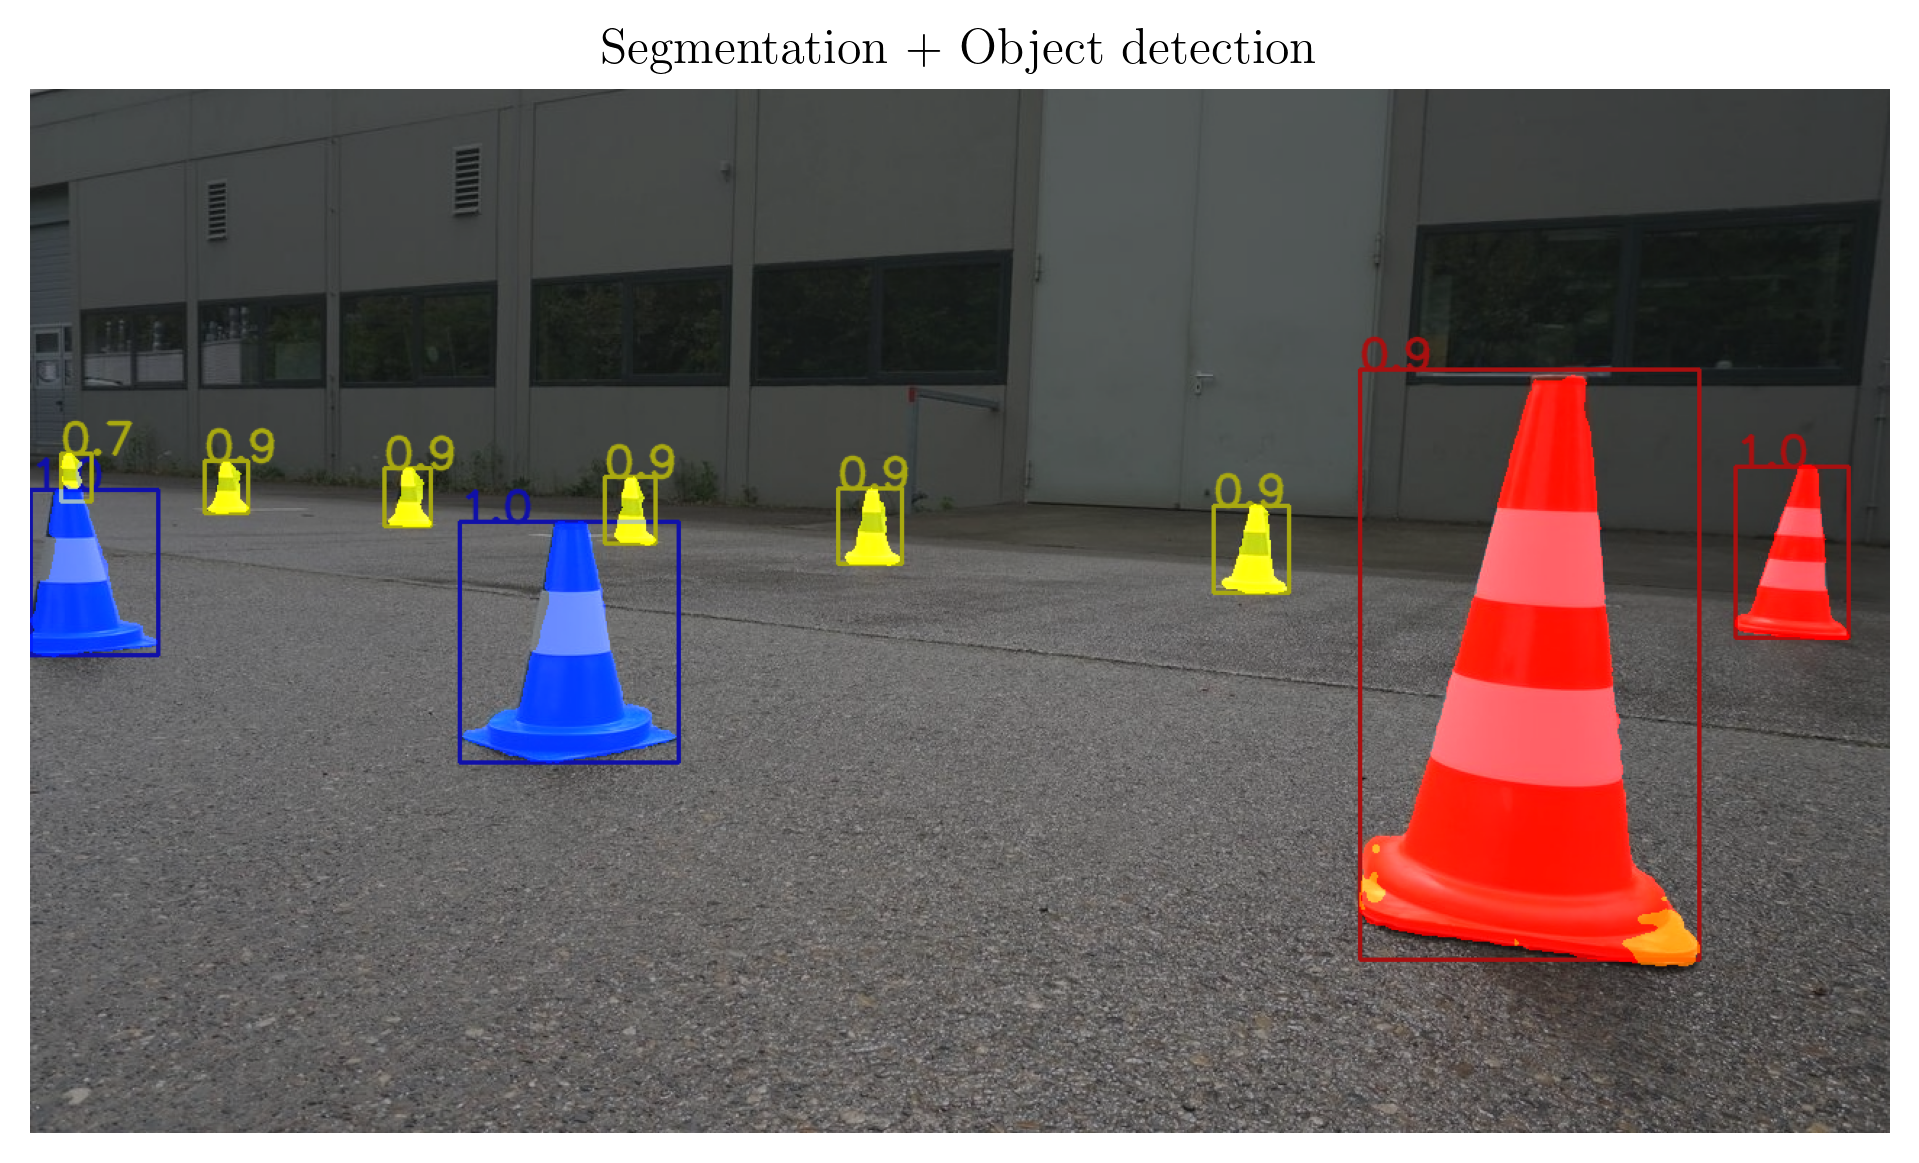

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300)
ax.imshow(mask_with_bboxes)
ax.set_title("Segmentation + Object detection")
ax.axis("off")
plt.show()